## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import demoji
import os
import pickle
import warnings

# helper libraries
from sklearn.model_selection import train_test_split, StratifiedKFold

# models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

warnings.filterwarnings("ignore")

*** Note: Data is manually cleaned after EDA

In [2]:
cwd=os.getcwd()
path_to_datafile = cwd+'/final_data_folder/Combined/ProcessedData_Cleaned_With_Model_updated_v2.xlsx'
bitcoin_data_final = pd.read_excel(path_to_datafile)

bitcoin_data_final['Checked FINAL (Manual)'] = bitcoin_data_final['Checked FINAL (Manual)'].fillna(1)
bitcoin_data_final = bitcoin_data_final.loc[bitcoin_data_final['Checked FINAL (Manual)'] == 1]

## Simple EDA

<AxesSubplot:xlabel='target'>

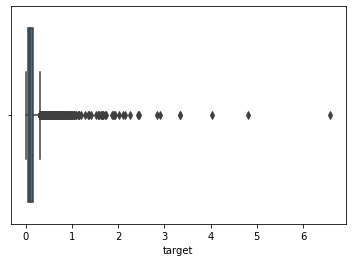

In [3]:
### remove numerical tokens
bitcoin_data_final['title_lemmatized_nonum'] = bitcoin_data_final['title_lemmatized'].apply(str).apply(lambda x: re.sub(r'\d+', '', x))

### convert emojis to list of emojis (str)
def convert_emoji_to_text(text):
    emoji_list = list(set(demoji.findall_list(text)))
    return ['emoji ' + i for i in emoji_list]
bitcoin_data_final['emojis'] = bitcoin_data_final['emojis'].apply(str).apply(lambda x: convert_emoji_to_text(x))

### target variable
bitcoin_data_final['target'] = bitcoin_data_final['Views']/(bitcoin_data_final['Subscribers'])
sns.boxplot(bitcoin_data_final['target'])

In [4]:
def remove_outlier_IQR(df):
    Q1=df['target'].quantile(0.25)
    Q3=df['target'].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df['target']<(Q1-1.5*IQR)) | (df['target']>(Q3+1.5*IQR)))]
    return df_final.reset_index(drop=True)

bitcoin_data_final = remove_outlier_IQR(bitcoin_data_final)

bitcoin_data_final.shape

(13675, 33)

In [5]:
### determine categorical and numerical features
numerical_ix = ['HashtagCount', 'ExclamationCount','QuestionCount', 'NumWords']
categorical_ix = ['HasHashtag','Total Seconds bins','HasCaps','HasPrediction','emojis']
text_chosen = 'title_lemmatized_nonum'

In [6]:
### setup explanatory and target variables
selected_cols =  numerical_ix + categorical_ix
selected_cols.append(text_chosen)

X, y = bitcoin_data_final[selected_cols],  bitcoin_data_final['target']

In [7]:
X.shape

(13675, 10)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle = True)

X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

<AxesSubplot:xlabel='target', ylabel='Count'>

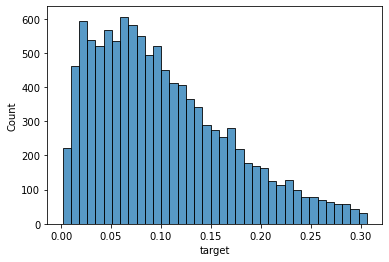

In [9]:
sns.histplot(y_train)

In [10]:
y_train.describe()

count    10940.000000
mean         0.101514
std          0.067178
min          0.001466
25%          0.048560
50%          0.088276
75%          0.142407
max          0.305940
Name: target, dtype: float64

## Objective Function

### Helper Functions

In [11]:
def evaluate(y_true, y_pred, vect, model, text_only=True, obj_func=False):
    """
    Main objective of this function is to calculate evaluation metrics such as RMSE and MSE based on given predicted and actual target values

    Parameters:
    ---------
    (1) y_true: actual target variable
    (2) y_pred: model predicted target variable
    (3) vect: vector used for text column (TfidfVectorizer / CountVectorizer)
    (4) model: regression model used to fit data
    (5) text_only (optional): boolean flag to indicate if only text data was used or not

    Returns:
    -------
    if obj_func = True:
        (1) dictionary of metric results
    else:
        (1) RMSE score
    
    """
    
    def mse(y_predicted, y_true):
        return np.mean(np.square(np.subtract(np.array(y_predicted), np.array(y_true))))
    
    mse = mse(y_pred, y_true)
    rmse = np.sqrt(mse)

    if obj_func:
        return rmse

    else:
        return {"MSE": mse, 
                "RMSE": rmse,
                "Vect Used": vect,
                "Model Used": model,
                "TextOnly": text_only}

def feature_encoding(X_train, X_test, vect, text_only=True):
    """
    Main objective of this function is to convert original dataset into features
        - text data to document term matrix
        - one hot encoding on emojis
        - one hot encoding on categorical variables
        - concatenate all features into a single df

    Parameters:
    ---------
    (1) X_train: training data set (done after kfold except testing on out-of-sample data)
    (2) X_test: test data set (done after kfold except testing on out-of-sample data)
    (3) vect: vector used for text column (TfidfVectorizer / CountVectorizer)
    (4) text_only (optional): boolean flag to indicate if only text data was used or not

    Returns:
    -------
    (1) X_train_combined: train df with all features concatenated to be fitted into model
    (2) X_test_combined: test df with all features concatenated to be tested
    
    """

    X_train_mat = vect.fit_transform(X_train[text_chosen])
    X_test_mat = vect.transform(X_test[text_chosen])
    features = vect.get_feature_names_out()

    X_train_dtm = pd.DataFrame(data=X_train_mat.toarray(), columns = features)
    X_test_dtm = pd.DataFrame(data=X_test_mat.toarray(), columns = features)
    
    if text_only:
        
        X_train_combined, X_test_combined = X_train_dtm, X_test_dtm

    else:
      
        # numerical features
        X_train_num_transformed = X_train[numerical_ix]
        X_test_num_transformed = X_test[numerical_ix]

        # emojis
        one_hot_emoji_train = pd.get_dummies(X_train['emojis'].apply(pd.Series).stack()).sum(level=0)
        one_hot_emoji_test = pd.get_dummies(X_test['emojis'].apply(pd.Series).stack()).sum(level=0)
        one_hot_emoji_test_dropped = one_hot_emoji_test.drop(columns=[x for x in one_hot_emoji_test.columns if x not in one_hot_emoji_train.columns])
        for col in one_hot_emoji_train.columns:
            if col not in one_hot_emoji_test_dropped.columns:
                one_hot_emoji_test_dropped[col] = 0

        # video length
        one_hot_seconds_train = pd.get_dummies(X_train['Total Seconds bins'].apply(pd.Series).stack()).sum(level=0) # one-hot encoding
        one_hot_seconds_train.columns = [x.replace('(','').replace(']','').replace(',', ' to') + ' seconds' for x in one_hot_seconds_train.columns]
        one_hot_seconds_test = pd.get_dummies(X_test['Total Seconds bins'].apply(pd.Series).stack()).sum(level=0) # one-hot encoding
        one_hot_seconds_test.columns = [x.replace('(','').replace(']','').replace(',', ' to') + ' seconds' for x in one_hot_seconds_test.columns]
        one_hot_seconds_test = one_hot_seconds_test.reindex(columns = one_hot_seconds_train.columns, fill_value=0)

        # combine all features
        X_train_combined = X_train_dtm.join(one_hot_emoji_train).join(one_hot_seconds_train).join(X_train[['HasHashtag','HasCaps','HasPrediction']]).join(X_train_num_transformed).fillna(0)
        X_test_combined = X_test_dtm.join(one_hot_emoji_test_dropped).join(one_hot_seconds_test).join(X_test[['HasHashtag','HasCaps','HasPrediction']]).join(X_test_num_transformed).fillna(0)
    
    return X_train_combined, X_test_combined

def create_folds(df, n_s, n_grp, plot=False):
    """
    Main objective of this function is to create stratified kfolds of the data
        - new added 'Fold' column is added from (0 to `n_s` - 1)

    Parameters:
    ---------
    (1) df: dataframe for k-fold to be performed on
    (2) n_s: number of folds
    (3) n_grp: number of bins to bin the target variable (the higher the better)
    (4) plot (optional): plot target variable distribution of each fold

    Returns:
    -------
    (1) df: df with added 'Fold' column
    
    """

    df['Fold'] = -1

    kf = StratifiedKFold(n_splits=n_s, shuffle=True)
    df['grp'] = pd.cut(df.target, n_grp, labels=False)
    target = df.grp

    for fold_no, (t, v) in enumerate(kf.split(target, target)):
        df.loc[v, 'Fold'] = fold_no
    
    ### plot k-fold distribution to ensure equal distribution
    if plot:
        fig, axs = plt.subplots(1, n_s, sharex=True, sharey=True, figsize=(10,4))
        for i, ax in enumerate(axs):
            ax.hist(df[df.Fold == i]['target'], bins=100, density=True, label=f'Fold-{i}')
            if i == 0:
                ax.set_ylabel('Frequency')
            if i == 2:
                ax.set_xlabel("Target")
            ax.legend(frameon=False, handlelength=0)
        plt.tight_layout()
        plt.show()

    return df.drop(columns=['grp'])

### Main Training Function

In [12]:
def resample_train_and_evaluate_model(x, y, vect, model, text_only=True, obj_function=False, plot=False):
    """

    This function performs Stratified KFold Cross Validation to evaluate the performance of models.
        1. Create k-folds with the data
        2. Iterate over each fold as the test set and the rest of the data as the train set.
        3. Perform feature encoding to prepare data for model fitting / prediction.
        4. Fit model & Predict on test set (fold)
        5. Evaluate results using RMSE and append to results table.

    Parameters:
    ---------
    (1) x
    (2) y
    (3) vect: vector used for text column (TfidfVectorizer / CountVectorizer)
    (4) model: regression model used to fit data
    (5) text_only (optional): boolean flag to indicate if only text data was used or not
    (6) obj_function (optional): boolean flag to indicate if used for hyperparameter tuning or not
    (6) plot (optional): plot target variable distribution of each fold

    Returns:
    -------
    if obj_function == True:
        (1) RMSE -> only used for hyperparameter tuning
    else:
        (1) dictionary of results to be appended to the results table
    
    """

    y_true, y_preds = [], []
    num_folds = 5
    num_bins = 5 # pseudo-categorical
    
    df = pd.concat([x,y], axis=1)
    folded_df = create_folds(df, num_folds, num_bins, plot)
  
    for i in tqdm(range(num_folds)):
        curr_train, curr_test = folded_df[df.Fold != i], folded_df[df.Fold == i]
        x_train, x_test = curr_train.drop(columns=['target','Fold']), curr_test.drop(columns=['target','Fold'])
        y_train, y_test = curr_train['target'], curr_test['target']

        x_train_df, x_test_df = feature_encoding(x_train, x_test, vect, text_only)

        model.fit(x_train_df, y_train)

        y_pred = model.predict(x_test_df)
        y_preds.extend(y_pred)
        y_true.extend(y_test)

    return evaluate(y_true, y_preds, vect, model, text_only, obj_function)

## Pick Best Text Model

### Helper Functions

In [13]:
### initialise df to store model results
res_test = pd.DataFrame()

def countvectorizer_evaluate(res_test, x, y, model):
    """

    This function evaluates the performance of using CountVectorizer over different hyperparameters.
        - done using Stratified KFold CV method

    Parameters:
    ---------
    (1) res_test: results dataframe
    (2) x
    (3) y
    (4) model: regression model used to fit data

    Returns:
    -------
    (1) res_test: results dataframe with updated results
    
    """

    count_vect_args = {'default':{},
                      'without setting to lowercase and remove stopwords':{'lowercase':False, 'stop_words':'english'},
                      'without setting to lowercase':{'lowercase':False},
                      }

    for k,v in tqdm(count_vect_args.items()):
        vect = CountVectorizer(**count_vect_args[k])
        results = resample_train_and_evaluate_model(x, y, vect, model)
        res_test=res_test.append(results,ignore_index=True)

    return res_test

def tfidfvectorizer_evaluate(res_test, x, y, model):
    """

    This function evaluates the performance of using TfidfVectorizer over different hyperparameters.
        - done using Stratified KFold CV method

    Parameters:
    ---------
    (1) res_test: results dataframe
    (2) x
    (3) y
    (4) model: regression model used to fit data

    Returns:
    -------
    (1) res_test: results dataframe with updated results
    
    """

    tfidf_vect_args = {'default':{},
                      'without setting to lowercase and remove stopwords':{'lowercase':False, 'stop_words':'english'},
                      'without setting to lowercase':{'lowercase':False},
                      }

    for k,v in tqdm(tfidf_vect_args.items()):
        vect = TfidfVectorizer(**tfidf_vect_args[k])
        results = resample_train_and_evaluate_model(x, y, vect, model)
        res_test=res_test.append(results,ignore_index=True)

    return res_test

### Test NLP Models

In [14]:
# Takes about 10mins
base_testing_model = tree.DecisionTreeRegressor(max_depth = 50, min_samples_split = 100, random_state=2022)
res_test = countvectorizer_evaluate(res_test, X_train, y_train, base_testing_model)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:39<00:00, 73.16s/it]


In [15]:
base_testing_model = tree.DecisionTreeRegressor(max_depth = 50, min_samples_split = 100, random_state=2022)
res_test = tfidfvectorizer_evaluate(res_test, X_train, y_train, base_testing_model)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:10<00:00, 83.63s/it]


In [16]:
res_test

,MSE,RMSE,Vect Used,Model Used,TextOnly
0,0.003994,0.063195,CountVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
1,0.003737,0.061131,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
2,0.003774,0.061430,CountVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
3,0.004327,0.065781,TfidfVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
4,0.003917,0.062585,"TfidfVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
5,0.003883,0.062314,TfidfVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0


## Build Model

In [17]:
vect = res_test.iloc[res_test[['RMSE']].idxmin()[0]]['Vect Used'] # get best text model

### Base Decision Tree Model

This is will be used as a baseline model comparison with the tuned model.

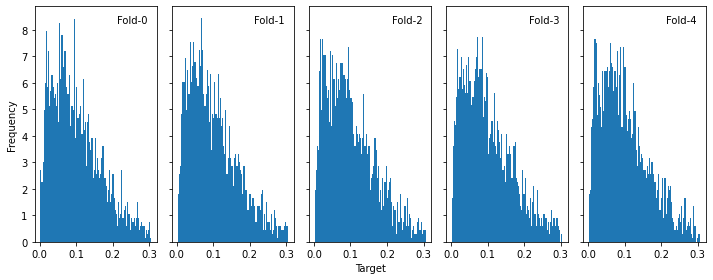

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.17s/it]


In [18]:
base_testing_model = tree.DecisionTreeRegressor(max_depth = 50, min_samples_split = 100, random_state=2022)
results_tree = resample_train_and_evaluate_model(X_train, y_train, vect, base_testing_model, text_only=False, plot=True)
res_test=res_test.append(results_tree,ignore_index=True)

In [19]:
res_test

,MSE,RMSE,Vect Used,Model Used,TextOnly
0,0.003994,0.063195,CountVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
1,0.003737,0.061131,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
2,0.003774,0.061430,CountVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
3,0.004327,0.065781,TfidfVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
4,0.003917,0.062585,"TfidfVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
5,0.003883,0.062314,TfidfVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
6,0.003824,0.061835,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",False


### Decision Tree with Bayes Optimisation Hyperparameter Tuning

#### Helper Functions

In [20]:
if not os.path.exists('/Tuning'): os.mkdir('/Tuning')
    
def save_file(path, data):
    """

    This function saves the model to a .pkl file.

    """

    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    """

    This function loads the model from a .pkl file.
    The main reason for doing so is that retraining is not required everytime the code is ran.

    """
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

def hyperopt(param_space, num_eval, vect, model):
    """
    Main hyperparameter tuning function

    Parameters:
    ---------
    (1) param_space: dictionary of parameter values to optimise
    (2) num_eval: number of iterations to optimise over
    (3) vect: vector used for text column
    (4) model: regression model used to fit data

    Returns:
    -------
    (1) trials: dictionary containing optimisation history (parameters, etc)
    (2) best_param_values: dictionary containing the parameters of best model (lowest RMSE)
    
    """

    def objective_function(params):
        """
        This function defines the objective function to minimise (in this case, RMSE)

        Parameters:
        ---------
        (1) params: model parameters

        Returns:
        -------
        (1) dictionary containing score (RMSE) and optimisation status
        
        """ 
        
        regressor = model(**params)
        score = resample_train_and_evaluate_model(X_train, y_train, vect, regressor, text_only=False, obj_function=True) # loss function is RMSE

        return {'loss': score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(2022))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    print(loss)
    return trials, best_param_values

#### Hyperparameter Tuning

In [21]:
num_eval = 100 # can increase more for more iterations

### defining parameter space
DT_param_hyperopt = {
    'splitter': hp.choice('splitter', ['best','random']),
    'max_depth': scope.int(hp.quniform('max_depth', 30, 150, 20)),
    'min_samples_split' : scope.int(hp.quniform('min_samples_split', 10, 150, 20)),
    'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf' : hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    'random_state':2022
}

In [22]:
load = True # toggle to set to False if want to re-optimise
if load == False:
    DT_hyperopt = hyperopt(DT_param_hyperopt, num_eval, vect, tree.DecisionTreeRegressor)
    save_file('Tuning/DT_hyperopt.pkl', DT_hyperopt)
else:
    try:
        DT_hyperopt = load_file('Tuning/DT_hyperopt.pkl')
    except Exception as e:
        print(e)

#### Visualise Hyperparameter Tuning History

In [23]:
trials = DT_hyperopt[0].trials

record = []
losses = []
for trial in trials:
    loss = trial["result"]["loss"]
    values = trial["misc"]['vals']
    losses.append(loss)
    record.append(values)
    
DTTrialsData = pd.DataFrame(record)
DTTrialsData = DTTrialsData.applymap(lambda x: x[0])

DTTrialsData.insert(0, 'loss', losses)
DTTrialsData.sort_values(by='loss', inplace=True)

In [24]:
DTTrialsData.head() # ordered by loss function in ascending order (first row is best hyperparameter)

,loss,max_depth,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,splitter
37,0.060281,80.0,9.0,80.0,0.001520,0
49,0.060581,60.0,4.0,100.0,0.001088,0
20,0.060646,80.0,6.0,60.0,0.001068,0
75,0.060779,100.0,9.0,60.0,0.000398,0
86,0.060823,80.0,9.0,60.0,0.000247,0


#### Fit and Test with Best Hyperparameters

In [25]:
dt_chosen = DT_hyperopt[1]

dt_model   =   tree.DecisionTreeRegressor(splitter=['best','random'][dt_chosen['splitter']], 
                                          max_depth=int(dt_chosen['max_depth']),
                                          min_samples_split = int(dt_chosen['min_samples_split']),
                                          min_samples_leaf = int(dt_chosen['min_samples_leaf']),
                                          min_weight_fraction_leaf = dt_chosen['min_weight_fraction_leaf'],
                                          random_state=2022)

In [26]:
res_test = res_test.append(resample_train_and_evaluate_model(X, y, vect, dt_model, text_only=False),ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:17<00:00, 15.44s/it]


In [27]:
sorted_res = res_test.sort_values(by = 'RMSE')
sorted_res # lower RMSE after tuning

,MSE,RMSE,Vect Used,Model Used,TextOnly
7,0.003631,0.060261,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=80, min_sample...",False
1,0.003737,0.061131,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
2,0.003774,0.061430,CountVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
6,0.003824,0.061835,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",False
5,0.003883,0.062314,TfidfVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
4,0.003917,0.062585,"TfidfVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
0,0.003994,0.063195,CountVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
3,0.004327,0.065781,TfidfVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0


## Testing Model on Out-of-Sample data

In [28]:
def evaluate_model(x_train, y_train, x_test, y_test, vect, model, text_only=False, obj_function=False):
    y_true, y_preds = [], []
    x_train_df, x_test_df = feature_encoding(x_train, x_test, vect, text_only)
    model.fit(x_train_df, y_train)
    y_pred = model.predict(x_test_df)
    y_preds.extend(y_pred)
    y_true.extend(y_test)

    return evaluate(y_true, y_preds, vect, model, text_only, obj_function)

results_test = evaluate_model(X_train, y_train, X_test, y_test, vect, dt_model, text_only=False, obj_function=False)
res_test=res_test.append(results_test,ignore_index=True)

In [29]:
res_test.iloc[len(res_test)-1] ## show latest result

MSE                                                    0.003748
RMSE                                                   0.061221
Vect Used     CountVectorizer(lowercase=False, stop_words='e...
Model Used    DecisionTreeRegressor(max_depth=80, min_sample...
TextOnly                                                  False
Name: 8, dtype: object

### Obtain Feature Importance

In [30]:
test_model = res_test.iloc[len(res_test)-1]['Model Used']

In [31]:
feature_impt = test_model.feature_importances_
x_train_df, x_test_df = feature_encoding(X_train, X_test, vect, False)
feature_names = x_train_df.columns
df = np.vstack((feature_impt, feature_names))

sorted_df = pd.DataFrame(df.T, columns=['Importance','Feature'])
sorted_df.Importance = sorted_df.Importance.astype(float)
sorted_df = sorted_df.sort_values(by = 'Importance', ascending=False)

In [32]:
sorted_df.head(50)

,Importance,Feature
595,0.148605,BITCOIN
8877,0.097900,NumWords
8875,0.067446,ExclamationCount
7979,0.067272,XRP
7249,0.054509,Technical
858,0.034975,Bitcoin
133,0.034112,ANALYSIS
42,0.029724,ADA
1451,0.025475,Chart
8116,0.019842,bitcoin


In [53]:
# sorted_df.to_csv('results/Feature_Importance.csv', index=False)

## Calculating the "Importance" of each Feature

In [54]:
x_train_df, x_test_df = feature_encoding(X_train, X_test, vect, False)

# Split the data into 3 equal bins where bin 1 has the smallest target variable and bin 3 has the largest
cuts = 3
x_train_df['Target_Bins'] = pd.qcut(y_train, q = cuts, labels=range(1,cuts+1))

In [55]:
x_train_df['Target_Bins'].value_counts()

1    3647
3    3647
2    3646
Name: Target_Bins, dtype: int64

In [56]:
# Before we can use this to calculate the "importance" of each token, we need to avoid dividing by zero and account for the class imbalance.

# number of times each token appears across the bottom bin
top_results = x_train_df[x_train_df['Target_Bins'] == cuts  ]
combined_results_df = pd.DataFrame(top_results.apply(lambda x : (sum(x)+1)/len(x)), columns= ['Top Mean'])

# number of times each token appears across the top bin
bottom_results = x_train_df[x_train_df['Target_Bins'] == 1 ]
combined_results_df['Bottom Mean'] = bottom_results.apply(lambda x : (sum(x)+1)/len(x))

In [57]:
# calculate the ratio of top bin to bottom bin for each token

combined_results_df['tokens to include'] = combined_results_df['Top Mean']/(combined_results_df['Bottom Mean'])
combined_results_df['tokens to avoid'] = combined_results_df['Bottom Mean']/(combined_results_df['Top Mean'])

In [58]:
combined_results_df['tokens to include'].sort_values(ascending= False)

8587.2 to 12876.3 seconds    55.000000
HEDERA                       46.500000
HBAR                         32.000000
emoji stop sign              30.000000
ROBINHOOD                    20.000000
                               ...    
NIOB                          0.062500
LOSSES                        0.062500
Corrective                    0.058824
Coin                          0.057143
CLIPS                         0.052632
Name: tokens to include, Length: 8879, dtype: float64

In [59]:
combined_results_df['tokens to avoid'].sort_values(ascending= False)

CLIPS                        19.000000
Coin                         17.500000
Corrective                   17.000000
LOSSES                       16.000000
NIOB                         16.000000
                               ...    
ROBINHOOD                     0.050000
emoji stop sign               0.033333
HBAR                          0.031250
HEDERA                        0.021505
8587.2 to 12876.3 seconds     0.018182
Name: tokens to avoid, Length: 8879, dtype: float64

In [60]:
combined_results = combined_results_df.merge(sorted_df, left_index=True, right_on='Feature').set_index('Feature')

In [61]:
# look up the importance_ratio for a given token
combined_results_df.loc['BITCOIN', 'tokens to include']

3.0374220374220373

In [62]:
# look up the importance_ratio for a given token
combined_results.loc['BITCOIN', ]

Top Mean             0.400603
Bottom Mean          0.131889
tokens to include    3.037422
tokens to avoid      0.329227
Importance           0.148605
Name: BITCOIN, dtype: float64

BITCOIN appears in the top bin 3 times more than the bottom bin

In [63]:
combined_results.to_csv('results/Feature Importance & Ratio.csv', index=True)